In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from optuna.samplers import TPESampler
import optuna
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from tqdm import tqdm
from lightgbm import LGBMRegressor
# min max scaling
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from utils.util_functions import calculate_mase2, reduce_mem_usage
from utils.lgb_feature_engineering_train import init_train_data
from utils.lgb_feature_engineering_train_test import init_train_data_keep
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

In [3]:
path_to_bu1 = "data/citylearn_challenge_2022_phase_1/Building_1.csv"
path_to_bu2 = "data/citylearn_challenge_2022_phase_1/Building_2.csv"
path_to_bu3 = "data/citylearn_challenge_2022_phase_1/Building_3.csv"
path_to_bu4 = "data/citylearn_challenge_2022_phase_1/Building_4.csv"
path_to_bu5 = "data/citylearn_challenge_2022_phase_1/Building_5.csv"

path_to_bu = [path_to_bu1, path_to_bu2, path_to_bu3, path_to_bu4, path_to_bu5]

x_train, y_train = pd.DataFrame(), pd.DataFrame()
for i in range(5):
        x, y = init_train_data(path_to_bu[i], 'cons')
        x['building_id'] = i
        x_train = x_train.append(x)
        y_train = y_train.append(y)
targets = [item for item in y_train.columns if 'Net_Future_' in item]

Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish


In [4]:
X_temp = x_train.drop(['day_year', 'building_id'], axis=1)
# 'net_target_diff',
features = X_temp.columns
categoricals = []
print(categoricals)
groups = x_train['building_id'].values
X_temp

[]


,Outdoor_Drybulb_Temperature,Relative_Humidity,Diffuse_Solar_Radiation,Direct_Solar_Radiation,hour_x,hour_y,month_x,month_y,weekday_x,weekday_y,...,Load_Past_20,Load_Past_21,Load_Past_22,Load_Past_23,Load_Past_24,Load_Past_25,Load_Past_26,Load_Past_27,Load_Past_28,Load_Past_29
30,18.906250,90.0,15.0,14.0,0.000000,1.000000,-0.500000,-0.866211,-0.222534,0.975098,...,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516,0.838379,0.834473,0.851074,2.275391
31,20.000000,87.0,116.0,42.0,-0.258789,0.965820,-0.500000,-0.866211,-0.222534,0.975098,...,0.618164,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516,0.838379,0.834473,0.851074
32,20.000000,87.0,252.0,74.0,-0.500000,0.866211,-0.500000,-0.866211,-0.222534,0.975098,...,0.645020,0.618164,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516,0.838379,0.834473
33,20.000000,84.0,292.0,35.0,-0.707031,0.707031,-0.500000,-0.866211,-0.222534,0.975098,...,0.764648,0.645020,0.618164,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516,0.838379
34,21.703125,76.0,436.0,95.0,-0.866211,0.500000,-0.500000,-0.866211,-0.222534,0.975098,...,1.432617,0.764648,0.645020,0.618164,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8732,18.296875,90.0,0.0,0.0,0.500000,-0.866211,-0.866211,-0.500000,1.000000,-0.000000,...,1.721680,1.154297,0.244263,0.738281,2.505859,2.728516,2.525391,2.279297,3.208984,2.968750
8733,18.906250,87.0,0.0,0.0,0.707031,-0.707031,-0.866211,-0.500000,1.000000,-0.000000,...,0.615723,1.721680,1.154297,0.244263,0.738281,2.505859,2.728516,2.525391,2.279297,3.208984
8734,19.406250,84.0,0.0,0.0,0.866211,-0.500000,-0.866211,-0.500000,1.000000,-0.000000,...,0.585938,0.615723,1.721680,1.154297,0.244263,0.738281,2.505859,2.728516,2.525391,2.279297
8735,18.906250,90.0,0.0,0.0,0.965820,-0.258789,-0.866211,-0.500000,1.000000,-0.000000,...,0.608887,0.585938,0.615723,1.721680,1.154297,0.244263,0.738281,2.505859,2.728516,2.525391


In [10]:
# print the list fully expanded
for col in X_temp.columns:
    print(col)

Outdoor_Drybulb_Temperature
Relative_Humidity
Diffuse_Solar_Radiation
Direct_Solar_Radiation
hour_x
hour_y
month_x
month_y
weekday_x
weekday_y
Outdoor_Drybulb_Temperature_0
Relative_Humidity_0
Diffuse_Solar_Radiation_0
Direct_Solar_Radiation_0
Outdoor_Drybulb_Temperature_1
Relative_Humidity_1
Diffuse_Solar_Radiation_1
Direct_Solar_Radiation_1
Outdoor_Drybulb_Temperature_2
Relative_Humidity_2
Diffuse_Solar_Radiation_2
Direct_Solar_Radiation_2
Outdoor_Drybulb_Temperature_3
Relative_Humidity_3
Diffuse_Solar_Radiation_3
Direct_Solar_Radiation_3
Outdoor_Drybulb_Temperature_4
Relative_Humidity_4
Diffuse_Solar_Radiation_4
Direct_Solar_Radiation_4
Outdoor_Drybulb_Temperature_5
Relative_Humidity_5
Diffuse_Solar_Radiation_5
Direct_Solar_Radiation_5
Outdoor_Drybulb_Temperature_6
Relative_Humidity_6
Diffuse_Solar_Radiation_6
Direct_Solar_Radiation_6
Outdoor_Drybulb_Temperature_7
Relative_Humidity_7
Diffuse_Solar_Radiation_7
Direct_Solar_Radiation_7
Outdoor_Drybulb_Temperature_8
Relative_Humidity_8

In [8]:
gbm = MultiOutputRegressor(
        LGBMRegressor(num_leaves=32, n_estimators=500, learning_rate=0.01, verbose=-1, random_state=42))
# gbm = MultiOutputRegressor(
#         LGBMRegressor(verbose=-1, random_state=42))

In [9]:
gbm.fit(X_temp, y_train)

MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.01,
                                             n_estimators=500, num_leaves=32,
                                             random_state=42, verbose=-1))

In [10]:
# Save to file in the current working directory
pkl_filename = "models/lgbm_direct24_solar_num_leaves_32.pkl"
with open(pkl_filename, 'wb') as file:
    pk.dump(gbm, file)

In [11]:
pkl_filename = "models/lgbm_direct24_solar_num_leaves_32.pkl"
# upload model from pkl_filename
with open(pkl_filename, 'rb') as file:
    gbm = pk.load(file)

In [12]:
# load the data for phase 2
path_to_bu1 = "data/citylearn_challenge_2022_phase_2/Building_6.csv"
path_to_bu2 = "data/citylearn_challenge_2022_phase_2/Building_7.csv"
path_to_bu3 = "data/citylearn_challenge_2022_phase_2/Building_8.csv"
path_to_bu4 = "data/citylearn_challenge_2022_phase_2/Building_9.csv"
path_to_bu5 = "data/citylearn_challenge_2022_phase_2/Building_10.csv"

path_to_bu = [path_to_bu1, path_to_bu2, path_to_bu3, path_to_bu4, path_to_bu5]

x_temp, y_temp = pd.DataFrame(), pd.DataFrame()
for i in range(5):
        x, y = init_train_data_keep(path_to_bu[i], 'solar')
        x['building_id'] = int(i)
        x_temp = x_temp.append(x)
        y_temp = y_temp.append(y)
x_temp = x_temp.loc[x_temp.index > 29] 
y_temp = y_temp.loc[y_temp.index > 29] 
x_temp = x_temp.loc[x_temp.index < 8735]
y_temp = y_temp.loc[y_temp.index < 8735]
targets = [item for item in y_train.columns if 'Net_Future_' in item]

Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish


In [13]:
Y_preds = gbm.predict(x_temp.drop(['building_id', 'day_year'], axis=1))

In [14]:
# upload together_forecast
tog_forecast = pd.read_csv('data/together_forecast/phase_2_forecast_sampled_1h.csv')
# drop first n rows to match the length of Y_preds
#tog_forecast = tog_forecast.iloc[-len(Y_preds):]
# sort by timestep adn then building
tog_forecast = tog_forecast.sort_values(by=['building', 'time_step'])
tog_forecast = tog_forecast.loc[tog_forecast['time_step'] > 29]
tog_forecast = tog_forecast.loc[tog_forecast['time_step'] > 29]
tog_forecast = tog_forecast.loc[tog_forecast['time_step'] < 8735]
tog_forecast = tog_forecast.loc[tog_forecast['time_step'] < 8735]
tog_forecast 

,time_step,scenario,building,+0h,+1h,+2h,+3h,+4h,+5h,+6h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
150,30,0,0,0.460339,0.022119,-0.351258,-0.452965,-0.675895,-0.785157,-0.590322,...,1.452454,1.452934,1.423195,1.291420,1.154592,1.027313,1.031311,1.170944,1.010131,0.859347
155,31,0,0,0.009526,-0.393807,-0.474856,-0.612209,-0.817454,-0.611549,-0.594651,...,1.401028,1.303515,1.301600,1.138323,1.020682,1.048768,1.172664,1.023978,0.891788,0.598346
160,32,0,0,0.030573,-0.172803,-0.487977,-0.750459,-0.575238,-0.637272,-0.323262,...,1.328569,1.255372,1.106127,1.004051,1.060574,1.179120,1.045212,0.922243,0.600979,0.107220
165,33,0,0,0.340553,-0.192889,-0.478996,-0.464763,-0.588090,-0.315790,0.202088,...,1.221677,1.130568,1.008835,1.030741,1.183927,1.062740,0.923408,0.673845,0.042621,-0.077499
170,34,0,0,-0.015013,-0.252191,-0.368618,-0.559074,-0.246726,0.153811,0.688794,...,1.116211,1.013040,1.042834,1.175591,1.037482,0.953707,0.598883,0.129233,-0.147204,-0.440944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43654,8730,0,4,2.345580,1.849300,1.387990,1.263436,1.246586,1.198015,1.070156,...,-0.399359,-1.061147,-1.566995,-1.598140,-1.869951,-1.577245,-1.005786,-0.041536,0.751993,1.613402
43659,8731,0,4,2.762508,1.777542,1.461604,1.367288,1.292668,1.160789,1.030964,...,-1.048222,-1.549567,-1.541089,-1.823467,-1.557654,-0.941106,-0.021388,0.977716,1.784600,2.122869
43664,8732,0,4,2.621168,1.899755,1.516814,1.396214,1.248202,1.115731,1.006332,...,-1.524518,-1.545510,-1.808305,-1.534177,-0.867887,0.108873,0.943125,1.968220,2.339056,2.168452
43669,8733,0,4,2.640710,1.901732,1.512708,1.319558,1.179127,1.088927,0.952294,...,-1.542367,-1.860795,-1.562315,-0.877587,0.128222,1.040751,1.911780,2.437180,2.280631,2.071981


In [15]:
Y_preds_df = pd.DataFrame(Y_preds, columns=tog_forecast.columns[3:])
y_temp.columns = tog_forecast.columns[3:]
Y_preds_df

,+0h,+1h,+2h,+3h,+4h,+5h,+6h,+7h,+8h,+9h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
0,37.687370,143.227188,324.882126,488.436970,600.803925,642.132250,663.431491,622.209567,544.804396,444.004863,...,1.957658,2.379425,2.016218,1.954021,1.998678,1.927467,1.939140,1.881219,1.909698,2.564224
1,155.535961,326.517652,475.417789,578.392052,649.465772,653.864388,629.502655,540.204104,452.264655,304.098429,...,1.957658,2.314935,1.929219,1.954021,1.998678,1.927467,1.939140,1.881219,2.433654,31.382011
2,349.227845,503.010239,596.724138,660.350495,679.393940,628.358182,541.826497,453.143660,299.516366,166.427545,...,1.942634,2.009507,1.929219,1.954021,1.998678,1.927467,1.939140,2.190393,32.702703,147.681320
3,486.880971,588.256711,658.108796,686.380477,645.506136,543.736456,458.362627,301.926772,165.533805,83.586349,...,1.911908,2.073997,1.929219,1.954021,1.998678,1.927467,2.055427,33.518486,157.322591,331.085234
4,610.115541,655.322974,687.800647,647.028645,572.922019,459.316675,297.020826,162.460061,85.520816,6.119097,...,1.926932,2.073997,1.929219,1.954021,1.998678,2.071066,33.829518,159.087945,329.593430,459.776006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43520,238.327863,38.099144,1.539415,1.763705,1.780576,1.930379,1.968063,1.900548,1.849916,1.876878,...,123.166251,267.846310,410.104468,508.821302,589.652167,651.134943,652.550279,610.832497,529.230762,400.035784
43521,36.301425,2.144103,1.720575,1.763705,1.773775,1.930379,1.968063,1.900548,1.849916,1.876878,...,265.948836,405.352453,506.988800,588.720274,649.909664,655.406417,606.752288,528.978166,404.760530,234.619891
43522,1.460453,1.617506,1.720575,1.763705,1.763185,1.930379,1.968063,1.900548,1.849916,1.876878,...,398.529316,514.792750,590.213778,654.936526,653.412134,607.643450,523.386215,407.426968,235.501752,26.685058
43523,1.306626,1.617506,1.720575,1.763705,1.763185,1.930379,1.968063,1.900548,1.849916,10.601099,...,518.063554,592.564306,651.363886,649.802189,608.938558,529.217823,405.202024,232.843141,29.495035,2.530932


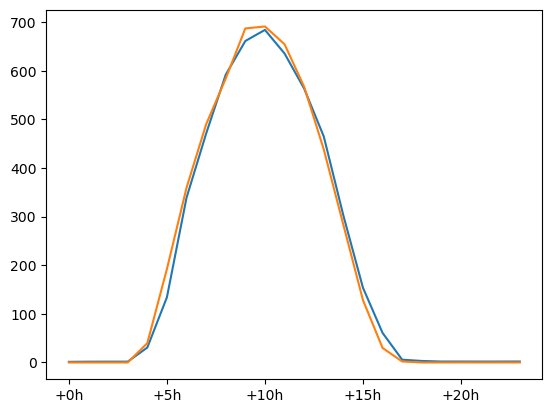

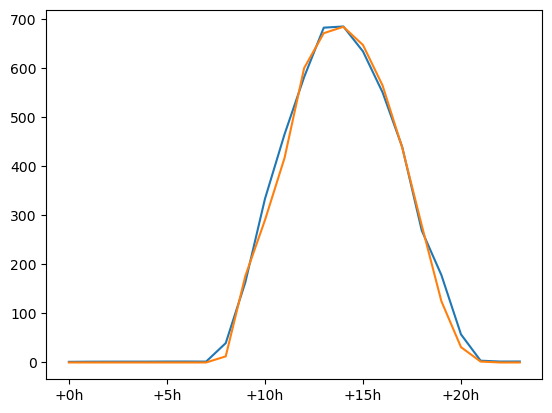

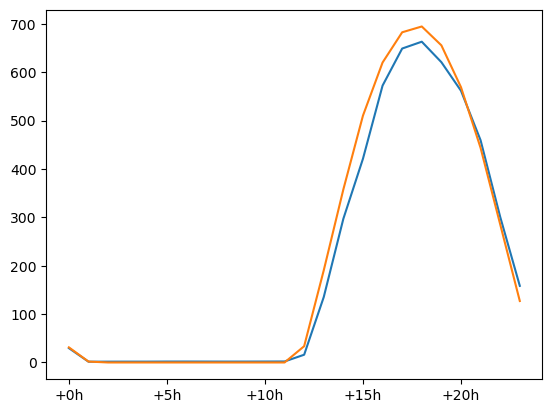

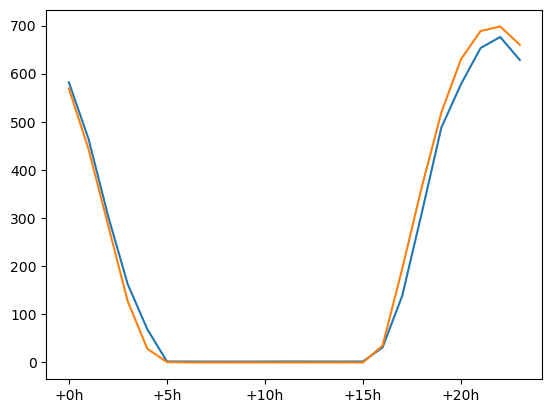

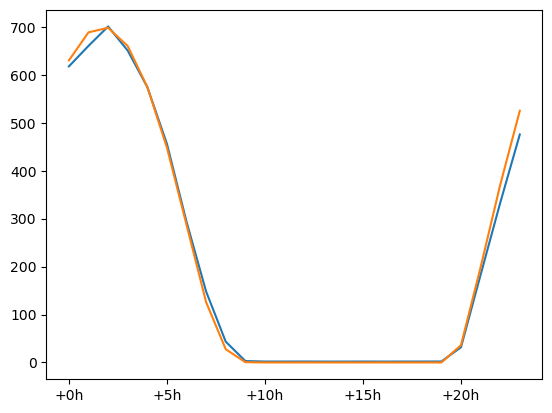

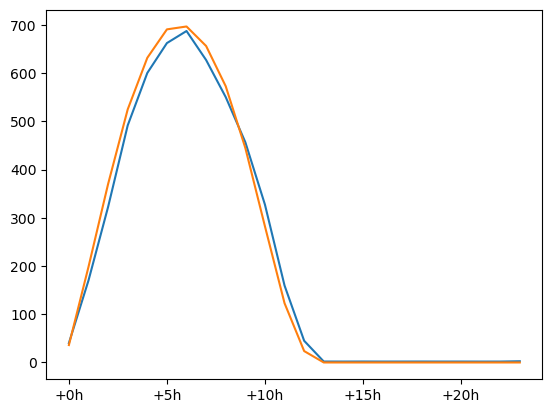

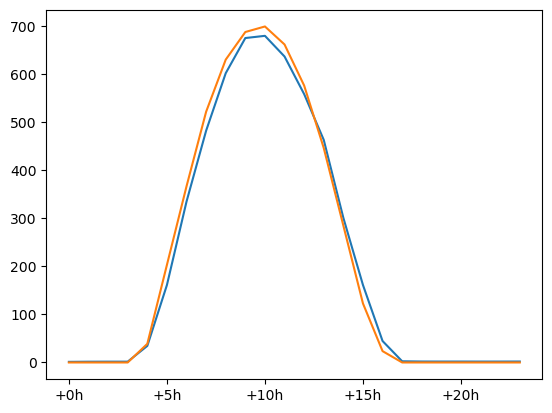

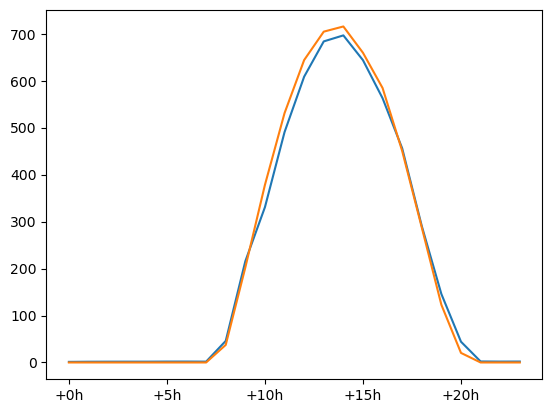

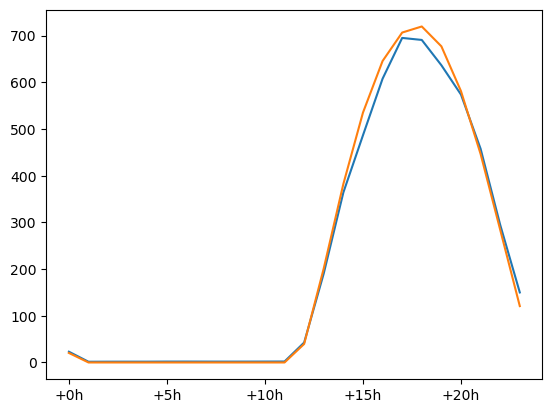

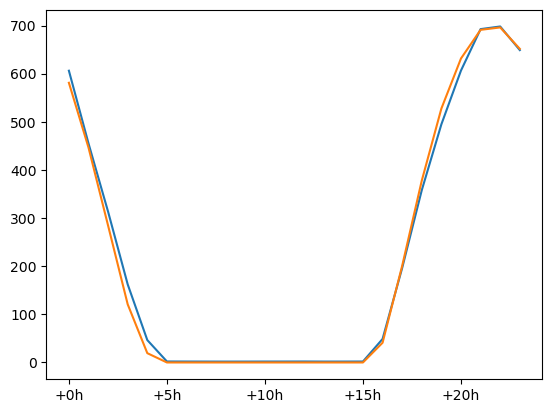

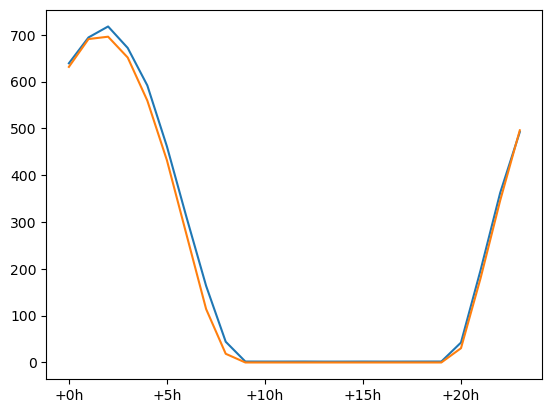

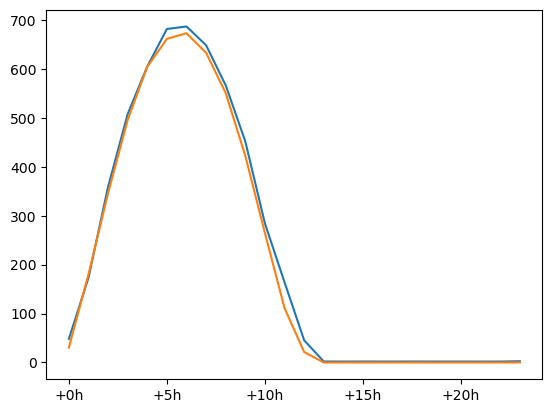

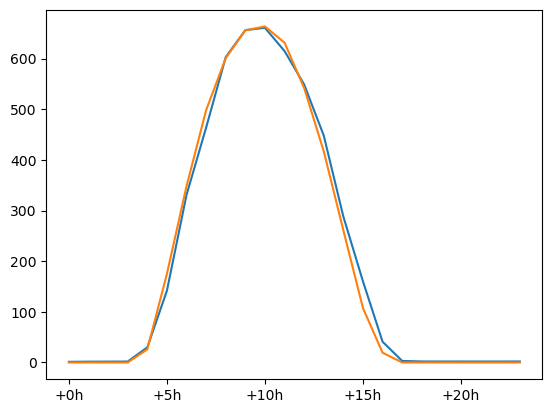

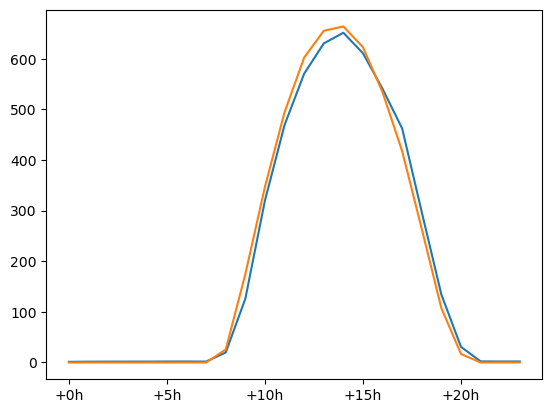

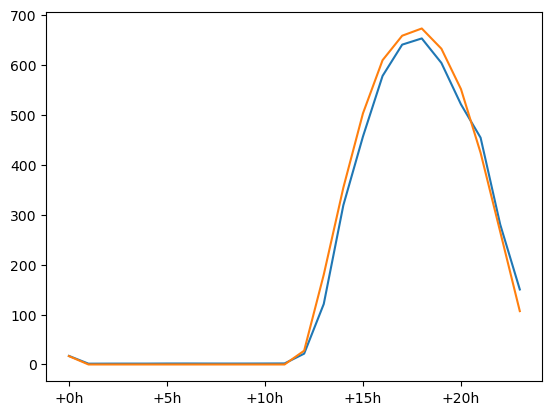

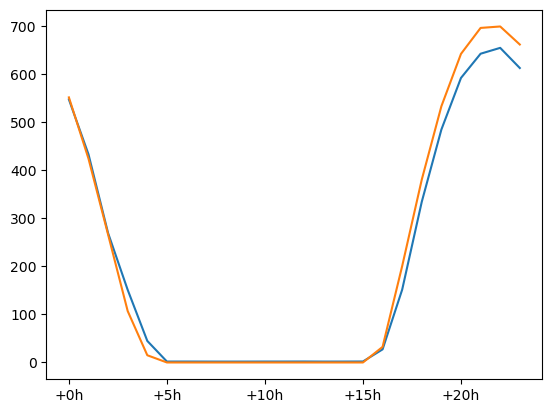

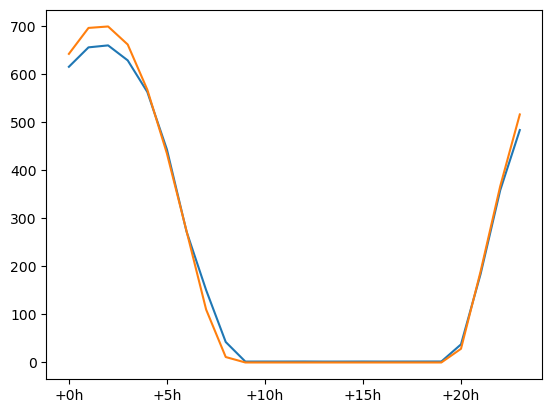

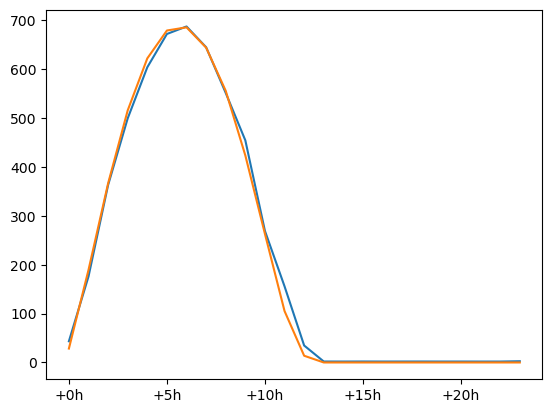

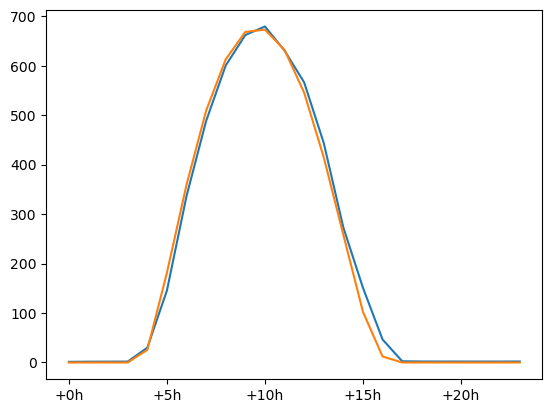

In [16]:
for i in range(20, 400, 20):
    Y_preds_df.iloc[i].plot()
    y_temp.iloc[i].plot()
    plt.show()

In [17]:
y_temp

,+0h,+1h,+2h,+3h,+4h,+5h,+6h,+7h,+8h,+9h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
30,175.00,347.25,498.75,604.0,665.50,682.00,641.00,558.000000,433.250000,281.000000,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.00000,0.00000,0.00000,39.68750
31,347.25,498.75,604.00,665.5,682.00,641.00,558.00,433.250000,281.000000,129.000000,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.00000,0.00000,39.68750,192.25000
32,498.75,604.00,665.50,682.0,641.00,558.00,433.25,281.000000,129.000000,33.656250,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.00000,39.68750,192.25000,359.25000
33,604.00,665.50,682.00,641.0,558.00,433.25,281.00,129.000000,33.656250,3.742188,...,0.0,0.0,0.0,0.0,0.0,0.0000,39.68750,192.25000,359.25000,489.75000
34,665.50,682.00,641.00,558.0,433.25,281.00,129.00,33.656250,3.742188,0.000000,...,0.0,0.0,0.0,0.0,0.0,39.6875,192.25000,359.25000,489.75000,584.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,25.00,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,...,263.5,406.5,530.0,603.5,673.5,672.0000,628.50000,551.00000,385.00000,194.00000
8731,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,...,406.5,530.0,603.5,673.5,672.0,628.5000,551.00000,385.00000,194.00000,15.53125
8732,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,11.742188,...,530.0,603.5,673.5,672.0,628.5,551.0000,385.00000,194.00000,15.53125,0.00000
8733,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.000000,11.742188,37.687500,...,603.5,673.5,672.0,628.5,551.0,385.0000,194.00000,15.53125,0.00000,0.00000


In [15]:
# evaluate MAE of together_forecast and Y_preds for each horizon
mae_lgbm = []
mae_tog = []
for i in range(24):
    mae_lgbm.append(mean_absolute_error(Y_preds_df.iloc[:,i], y_temp.iloc[:,i]))
    mae_tog.append(mean_absolute_error(tog_forecast.iloc[:,i+3], y_temp.iloc[:,i]))

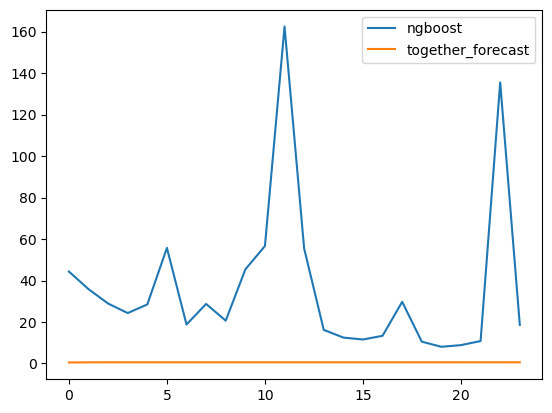

In [16]:
# plot MAE for each horizon
plt.plot(mae_lgbm, label='ngboost')
plt.plot(mae_tog, label='together_forecast')
plt.legend()
plt.show()

In [66]:
# test best model
Y_preds = best_model.predict(X_temp)
Y_dists = best_model.pred_dist(X_temp)
# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, y_test)
print("Test MSE", test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(y_test).mean()
print("Test NLL", test_NLL)


ValueError: Found input variables with inconsistent numbers of samples: [43645, 8729]

In [60]:
joblib.dump(best_model, 'models/ngboost/ngboost_next_step.pkl')

['models/ngboost/ngboost_next_step.pkl']